In [1]:
from __future__ import print_function

from tensorflow import keras
import numpy as np
import pandas as pd

ImportError: DLL load failed while importing _multiarray_umath: No se puede encontrar el módulo especificado.

https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline/blob/master/FCN.py


In [2]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Función para leer y procesar el archivo CSV
def load_and_preprocess_data(filename):
    # Leer el archivo CSV
    df = pd.read_csv(filename)

    df = df[df['stimuli'] == 'flash']

    # Realizar el split basado en el id del paciente
    unique_ids = df['id'].unique()
    train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=26)

    train_set = df[df['id'].isin(train_ids)]
    test_set = df[df['id'].isin(test_ids)]

    # Descartar las columnas no necesarias
    train_set = train_set.drop(columns=['id', 'eye', 'stimuli', 'color'])
    test_set = test_set.drop(columns=['id', 'eye', 'stimuli', 'color'])

    # Convertir la columna 'glaucoma' en etiquetas binarias
    train_set['glaucoma'] = train_set['glaucoma'].apply(lambda x: 1 if x == 'yes' else 0)
    test_set['glaucoma'] = test_set['glaucoma'].apply(lambda x: 1 if x == 'yes' else 0)

    # Separar las etiquetas de las características
    y_train = train_set['glaucoma'].values
    X_train = train_set.drop(columns=['glaucoma']).values

    y_test = test_set['glaucoma'].values
    X_test = test_set.drop(columns=['glaucoma']).values

    return X_train, y_train, X_test, y_test

# Uso de la función
filename = 'dataset_sat_fill.csv'
x_train, y_train, x_test, y_test = load_and_preprocess_data(filename)

# Dividir el conjunto de entrenamiento en un conjunto de entrenamiento y uno de validación
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=26)

In [5]:
print()
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')


x_train shape: (204, 2770)
x_val shape: (52, 2770)
x_test shape: (72, 2770)
204 train samples
52 validation samples
72 test samples


In [6]:
# Configuración del modelo
nb_epochs = 1000
nb_classes = len(np.unique(y_test))  # En este caso, debería ser 2 (para 'yes' y 'no')
batch_size = min(x_train.shape[0] // 10, 16)
print(nb_classes)

2


In [7]:
# Convertir las etiquetas a una representación categórica
Y_train = keras.utils.to_categorical(y_train, nb_classes)
Y_val = keras.utils.to_categorical(y_val, nb_classes)
Y_test = keras.utils.to_categorical(y_test, nb_classes)

# Normalizar las características
x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std
x_val = (x_val - x_train_mean) / x_train_std

# Reformatear los datos para el modelo de Keras
x_train = x_train.reshape(x_train.shape + (1, 1,))
x_test = x_test.reshape(x_test.shape + (1, 1,))
x_val = x_val.reshape(x_val.shape + (1, 1,))

In [8]:
# Definir el modelo
x = keras.layers.Input(x_train.shape[1:])
conv1 = keras.layers.Conv2D(128, 8, 1, padding='same')(x)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation('relu')(conv1)

conv2 = keras.layers.Conv2D(256, 5, 1, padding='same')(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.Activation('relu')(conv2)

conv3 = keras.layers.Conv2D(128, 3, 1, padding='same')(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.Activation('relu')(conv3)

full = keras.layers.GlobalAveragePooling2D()(conv3)
out = keras.layers.Dense(nb_classes, activation='softmax')(full)

model = keras.models.Model(inputs=x, outputs=out)

In [9]:
# Compilar el modelo
optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Configurar la reducción de la tasa de aprendizaje
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                                              patience=50, min_lr=0.0001)

from tensorflow.keras.callbacks import ModelCheckpoint

# Configurar el callback para guardar el mejor modelo
checkpoint = ModelCheckpoint('best_model_6.h5', monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=1)

In [10]:
# Entrenar el modelo usando el conjunto de validación en lugar del conjunto de prueba
hist = model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epochs,
                 verbose=1, validation_data=(x_val, Y_val), callbacks=[reduce_lr, checkpoint])

Epoch 1/1000
13/13 [==============================] - ETA: 0s - loss: 0.8218 - accuracy: 0.5049
Epoch 1: val_accuracy improved from -inf to 0.51923, saving model to best_model_6.h5
13/13 [==============================] - 7s 240ms/step - loss: 0.8218 - accuracy: 0.5049 - val_loss: 0.6897 - val_accuracy: 0.5192 - lr: 0.0010
Epoch 2/1000
12/13 [==========================>...] - ETA: 0s - loss: 0.6583 - accuracy: 0.6042
Epoch 2: val_accuracy did not improve from 0.51923
13/13 [==============================] - 1s 70ms/step - loss: 0.6573 - accuracy: 0.6029 - val_loss: 0.7075 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/1000
12/13 [==========================>...] - ETA: 0s - loss: 0.6085 - accuracy: 0.6510
Epoch 3: val_accuracy did not improve from 0.51923
13/13 [==============================] - 1s 70ms/step - loss: 0.6167 - accuracy: 0.6471 - val_loss: 0.7103 - val_accuracy: 0.4038 - lr: 0.0010
Epoch 4/1000
12/13 [==========================>...] - ETA: 0s - loss: 0.6047 - accuracy: 0.6302

In [11]:
log = pd.DataFrame(hist.history)

# Encuentra el índice de la menor pérdida
min_loss_index = log['loss'].idxmin()

# Asegúrate de que el índice es un número entero
print("Min loss index:", min_loss_index)

# Accede a la pérdida mínima y la precisión de validación
min_loss = log.loc[min_loss_index, 'loss']
val_accuracy_at_min_loss = log.loc[min_loss_index, 'val_accuracy']

# Imprime los resultados
print(min_loss, val_accuracy_at_min_loss)

Min loss index: 994
0.09076379984617233 0.75


In [12]:
min_loss_index = log['val_loss'].idxmin()
print("Min val_loss index:", min_loss_index)
min_loss = log.loc[min_loss_index, 'val_loss']
val_accuracy_at_min_loss = log.loc[min_loss_index, 'val_accuracy']
print(min_loss, val_accuracy_at_min_loss)

Min val_loss index: 559
0.5075222849845886 0.7115384340286255


In [13]:
model = keras.models.load_model('best_model_6.h5')

3/3 [==============================] - 2s 284ms/step
Test Accuracy: 0.54
2/2 [==============================] - 1s 830ms/step
Val Accuracy: 0.81


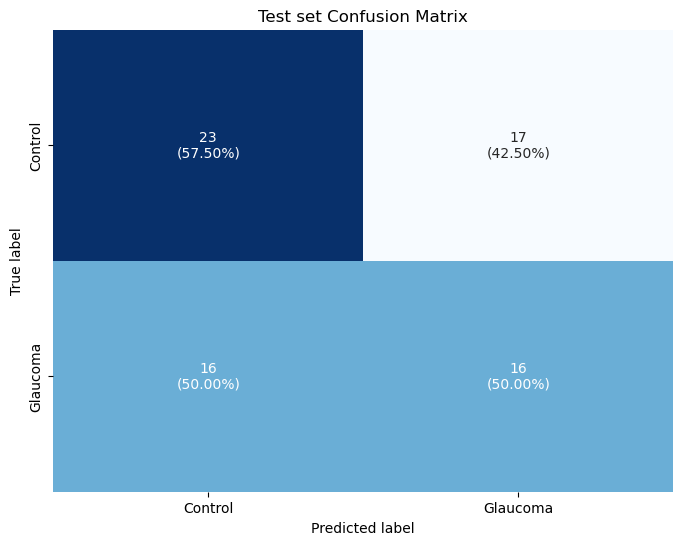

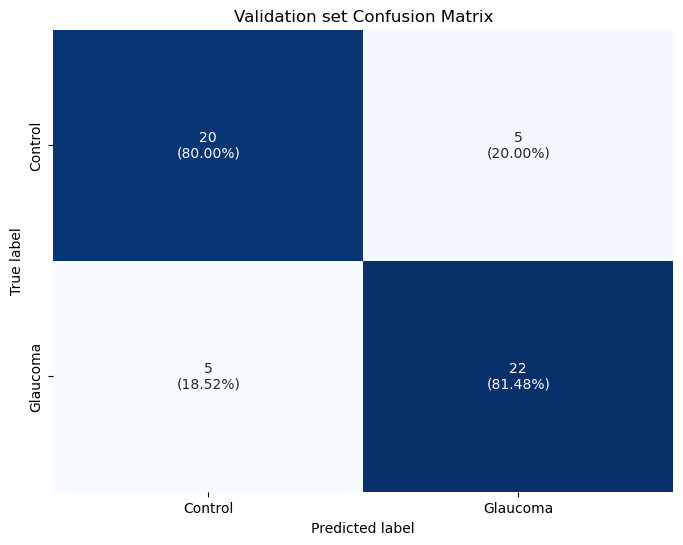

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Realizar las predicciones en el conjunto de prueba
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)  # Convertir las predicciones en etiquetas de clase

# Calcular el accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {accuracy:.2f}")

y_val_pred = model.predict(x_val)
y_val_pred_classes = y_val_pred.argmax(axis=1)
val_accuracy = accuracy_score(y_val, y_val_pred_classes)
print(f"Val Accuracy: {val_accuracy:.2f}")

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Calcular la matriz de confusión normalizada
conf_matrix_normalized = confusion_matrix(y_test, y_pred_classes, normalize='true')

# Crear una anotación que incluya tanto el valor absoluto como el porcentaje
labels = np.asarray([f'{int(conf_matrix[i, j])}\n({conf_matrix_normalized[i, j]:.2%})' 
                     for i in range(conf_matrix.shape[0]) 
                     for j in range(conf_matrix.shape[1])]).reshape(conf_matrix.shape)

# Definir las etiquetas personalizadas
class_names = ['Control', 'Glaucoma']

# Graficar la matriz de confusión con los valores absolutos y normalizados
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Test set Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val, y_val_pred_classes)

# Calcular la matriz de confusión normalizada
conf_matrix_normalized = confusion_matrix(y_val, y_val_pred_classes, normalize='true')

# Crear una anotación que incluya tanto el valor absoluto como el porcentaje
labels = np.asarray([f'{int(conf_matrix[i, j])}\n({conf_matrix_normalized[i, j]:.2%})' 
                     for i in range(conf_matrix.shape[0]) 
                     for j in range(conf_matrix.shape[1])]).reshape(conf_matrix.shape)

# Definir las etiquetas personalizadas
class_names = ['Control', 'Glaucoma']

# Graficar la matriz de confusión con los valores absolutos y normalizados
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Validation set Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

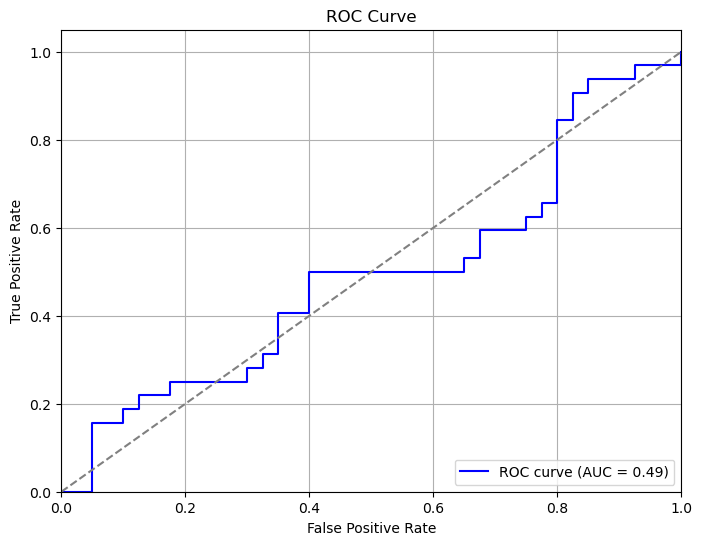

AUC: 0.49


In [15]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Obtener las probabilidades de clase positiva
y_prob = y_pred[:, 1]  # Asegúrate de que sea la probabilidad de la clase positiva (glaucoma)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcular el AUC
auc_value = roc_auc_score(y_test, y_prob)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Imprimir el valor del AUC
print(f"AUC: {auc_value:.2f}")

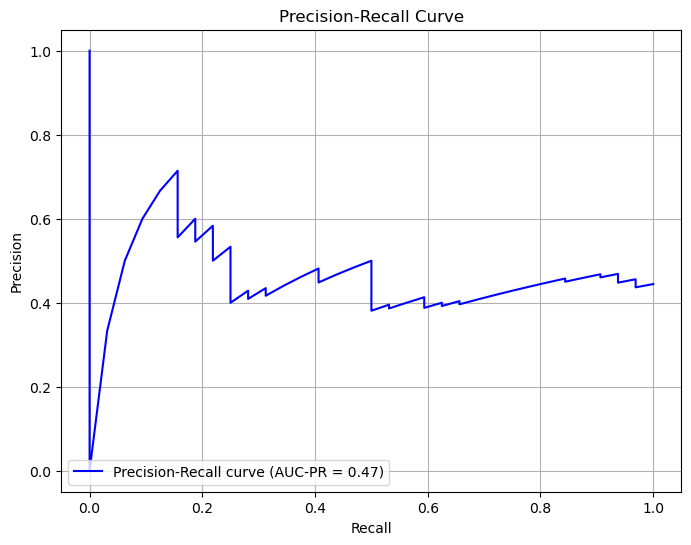

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calcular la curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Calcular el AUC-PR
auc_pr = average_precision_score(y_test, y_prob)

# Graficar la curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AUC-PR = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

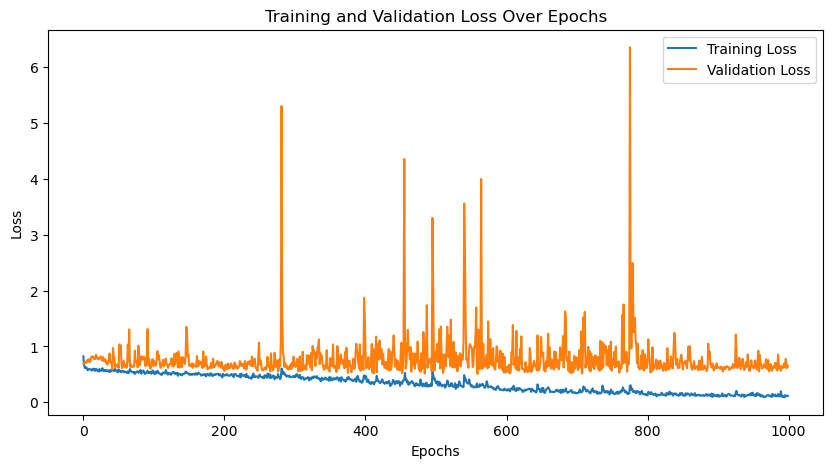

In [17]:
import matplotlib.pyplot as plt

# Crear un gráfico de las pérdidas a través de las épocas
plt.figure(figsize=(10, 5))
plt.plot(log['loss'], label='Training Loss')
plt.plot(log['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

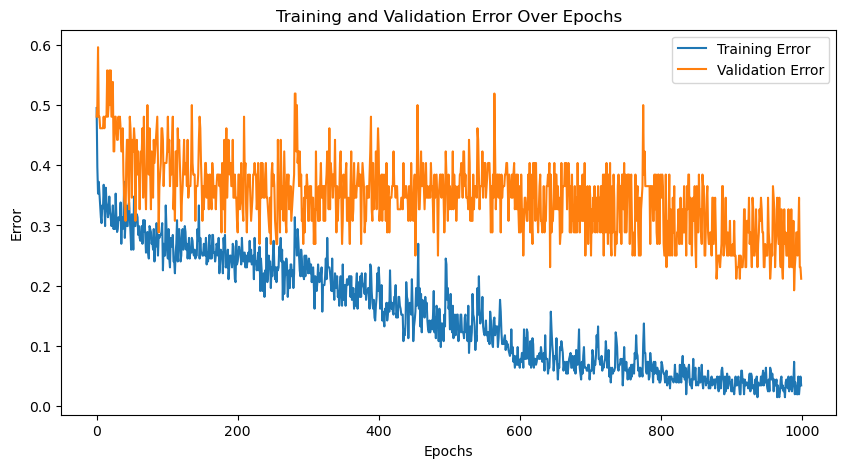

In [18]:
# Calcular el error como 1 - accuracy
train_error = 1 - log['accuracy']
val_error = 1 - log['val_accuracy']

# Crear un gráfico del error a través de las épocas
plt.figure(figsize=(10, 5))
plt.plot(train_error, label='Training Error')
plt.plot(val_error, label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training and Validation Error Over Epochs')
plt.legend()
plt.show()